In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from fetch.oai.oai import OAIVOLTXDS, ZIBDS
import monai.transforms as MT
import fetch.transforms as T
import torch
from torchvision.transforms import ToPILImage
from PIL import Image
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import PIL
import pandas as pd


In [3]:
k_img=['IMAGE_PATH_SAG_3D_DESS']
k_mask=['mask']
img_size=(160, 384, 384)

tx = MT.Compose([
    MT.Lambdad(k_img, T.load_targz),
    MT.Lambdad(k_mask, T.load_mhd),
    MT.Lambdad(k_img + k_mask, lambda x: x.swapaxes(-1, 0)),
    MT.Lambdad(k_mask, lambda x: x.rot90(k=1, dims=[-2,-1])),
    MT.ScaleIntensityRangePercentilesd(k_img, lower=0.5, upper=99.5, b_min=0, b_max=1, clip=True, relative=False),
    MT.Lambdad(k_img + k_mask, lambda x: x.unsqueeze(0)),
    MT.ResizeWithPadOrCropd(k_img + k_mask, img_size),
    MT.AsDiscreted(k_mask, to_onehot=5),
    # MT.Resized(k_img, img_size, mode='linear'),
    # MT.Resized(k_mask, img_size, mode='nearest'),
    # MT.CastToTyped(k_mask, torch.uint8),
    MT.ToTensor(track_meta=False),
])

tensor2pil = ToPILImage()

class ZIBDataset(OAIVOLTXDS):
    def __init__(self, transforms=tx):
        super().__init__(transforms=transforms)
        zds = ZIBDS()

        self.df = self.df.merge(zds.df, left_on='IMAGE_PATH_SAG_3D_DESS', right_on='IMAGE_PATH', validate='1:1')
        self.sequences = k_img + k_mask

    def __getitem__(self, ndx):
        ret = super().__getitem__(ndx)
        ret['img'] = self.transforms({k: ret[k] for k in self.sequences})
        return ret

In [60]:
ds = ZIBDataset()

In [ ]:
%matplotlib widget
import ipywidgets as widgets
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import numpy as np

# Initialize lists to store coordinates for each image
femur_coords = {}
patella_coords = {}
tibia_coords = {}

# Variable to keep track of which part is being clicked
current_part = 'femur'
current_image_index = 0
cid = None

def onclick(event):
    global current_part, current_image_index, cid, indexindex
    x, y = event.xdata, event.ydata
    if x is not None and y is not None:  # Ensure the click is within the plot area
        if current_part == 'femur':
            femur_coords[current_image_index] = (x, y)
            current_part = 'patella'
            ax.set_title(f'{current_image_index}: Click on the Patella')
            plt.draw()  # Update the plot title
        elif current_part == 'patella':
            patella_coords[current_image_index] = (x, y)
            current_part = 'tibia'
            ax.set_title(f'{current_image_index}: Click on the Tibia')
            plt.draw()  # Update the plot title
        elif current_part == 'tibia':
            tibia_coords[current_image_index] = (x, y)
            current_image_index += 1
            if current_image_index < len(ds):
                current_part = 'femur'
                fig.canvas.mpl_disconnect(cid)
                show_next_image()
            else:
                fig.canvas.mpl_disconnect(cid)
                print("All images processed.")
                print("Femur coordinates:", femur_coords)
                print("Tibia coordinates:", tibia_coords)
                clear_output(wait=True)

def show_next_image():
    global fig, ax, cid
    clear_output(wait=True)
    dess = np.array(PIL.Image.open(ds.df['IMAGE_PATH_SAG_3D_DESS'].str.replace('.tar.gz','_jpg/080.jpg').iloc[indexindex]))
    fig, ax = plt.subplots()
    ax.matshow(dess, cmap='gray')
    ax.set_title(f'{current_image_index}: Click on the Femur')
    cid = fig.canvas.mpl_connect('button_press_event', onclick)
    plt.show()

# Start by showing the first image
show_next_image()

In [ ]:
### SAVE coords to coords.csv

In [78]:
for _, row in pd.read_csv('coords.csv').iterrows():
    fig, ax = plt.subplots()
    ax.matshow(np.array(PIL.Image.open(row['jpg'])), cmap='gray')
    ax.scatter(row['femur_x'], row['femur_y'], c='r')
    ax.scatter(row['patella_x'], row['patella_y'], c='y')
    ax.scatter(row['tibia_x'], row['tibia_y'], c='g')
    plt.savefig(f"/home/asy51/repos/fetch/tmp/{row['jpg'].replace('/','-')}.jpg")
    plt.close()
    print(f"/home/asy51/repos/fetch/tmp/{row['jpg'].replace('/','-')}.jpg")

/home/asy51/repos/fetch/tmp/-home-asy51-vstor-data-oai-image03-00m-0.E.1-9624170-20050930-10600514_jpg-080.jpgYAY.jpg
/home/asy51/repos/fetch/tmp/-home-asy51-vstor-data-oai-image03-00m-0.C.2-9788072-20050418-10378312_jpg-080.jpgYAY.jpg
/home/asy51/repos/fetch/tmp/-home-asy51-vstor-data-oai-image03-00m-0.E.1-9002430-20050620-10934812_jpg-080.jpgYAY.jpg


No such comm: 06641c6719d54259b431b003392542f3


In [5]:
### DESS to JPG
# ret = []
# for d in ds:
    # dess = d['img']['IMAGE_PATH_SAG_3D_DESS'][0]
    # dst = f"{d['IMAGE_PATH_SAG_3D_DESS'].replace('.tar.gz','_jpg')}"
    # print(dst)
    # plt.matshow(dess[80], cmap='gray')
    # plt.title(dst.replace('/home/asy51/vstor/data/oai/image03/00m/', ''))
    # plt.savefig('/home/asy51/repos/fetch/tmp/' + dst.replace('/home/asy51/vstor/data/oai/image03/00m/', '').replace('_','.').replace('/','_'))

    # os.makedirs(dst, exist_ok=True)
    # # mask = d['img']['mask'] # 5 channels
    # for slc_ndx in range(dess.shape[0]):
    #     dess_slc = tensor2pil(dess[slc_ndx])
    #     dess_slc.convert('L').save(f"{dst}/{slc_ndx:03d}.jpg", 'JPEG')
    #     # print(f"{dst}/{slc_ndx:03d}.jpg")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


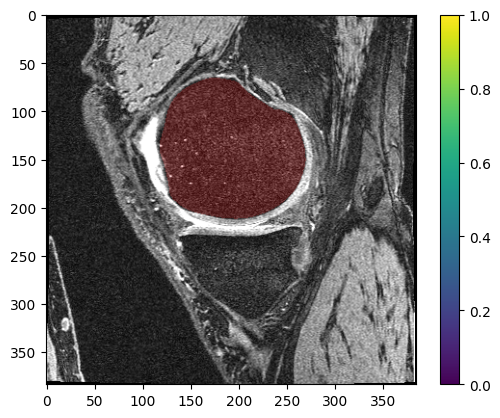

In [110]:
### MANUAL MASKS
from fetch.util import mask_overlay
masked = mask_overlay(d['img']['IMAGE_PATH_SAG_3D_DESS'][0], d['img']['mask'][1])
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
im = ax.imshow(masked[130])
# im = ax.imshow(d['img']['IMAGE_PATH_SAG_3D_DESS'][0][130], cmap='gray')
# im = ax.imshow(d['img']['mask'][1][130])
plt.colorbar(im, ax=ax)